In [10]:
from elite_trader.auth import authenticate

authenticate("czl", "Vnpy1234")
from useful_tools import *
import matplotlib.pyplot as plt

In [6]:
import talib as ta
import pandas as pd
from pandas_ta import log_return
import numpy as np

In [41]:
from sklearn.preprocessing import StandardScaler

In [59]:
df = load_essentials("rb99", "2019-01-01", "2019-12-31", "SHFE")
scaler = StandardScaler()

In [60]:
df["50m_ret"] = scaler.fit_transform(
    log_return(df.close, length=50, offset=-50).values.reshape(-1, 1)
)

In [82]:
df["pos"] = df["50m_ret"] * 10
df.fillna(0, inplace=True)

In [91]:
df.pos = df.pos.apply(int)

In [92]:
df["pricechange"] = df["close"].shift(-50) - df["open"]
df["balance"] = (df["pricechange"] * df.pos).cumsum()

In [109]:
df["num_index"] = list(range(len(df)))

<AxesSubplot:xlabel='num_index'>

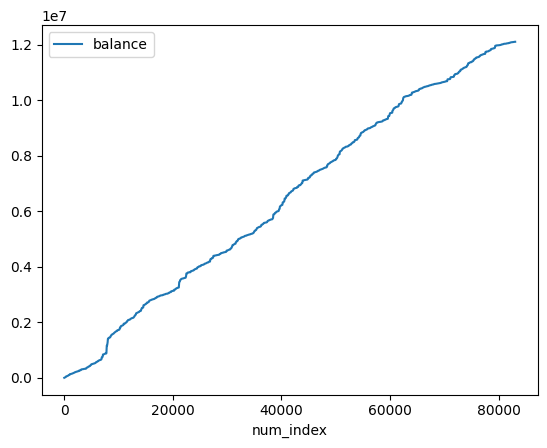

In [112]:
df.plot(x="num_index", y="balance")

In [121]:
df["pos_rolling"] = df["pos"].rolling(50, min_periods=1).sum()

<AxesSubplot:xlabel='num_index'>

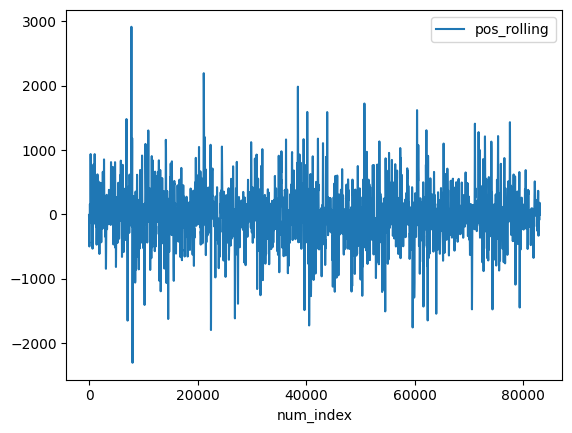

In [122]:
df.plot(x="num_index", y="pos_rolling")

<AxesSubplot:xlabel='datetime'>

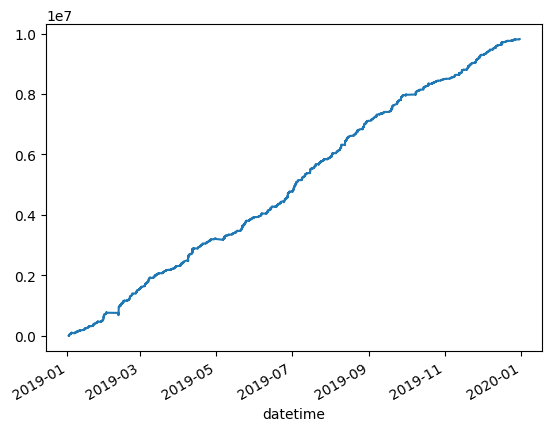

In [123]:
df["balance_2"] = df.pos_rolling * (df.close - df.open)
df.balance_2.cumsum().plot()

In [149]:
def prepare_desired_pos(df, lag=50, multiplier=10):
    scaler = StandardScaler()
    df[f"{lag}m_ret"] = scaler.fit_transform(
        log_return(df.close, length=lag, offset=-lag).values.reshape(-1, 1)
    )
    df.dropna(inplace=True)
    df["pos_change"] = df[f"{lag}m_ret"] * multiplier
    df["pos_change"] = df["pos_change"].apply(int)
    df["pos_rolling"] = df["pos_change"].rolling(lag, min_periods=1).sum()
    df.drop(columns=[f"{lag}m_ret"], inplace=True)


def generate_simple_features(df):
    df["open_change"] = df.open.pct_change(50)
    df["high_change"] = df.high.pct_change(50)
    df["low_change"] = df.low.pct_change(50)
    df["close_change"] = df.close.pct_change(50)
    df["volume_change"] = df.volume.pct_change(50)
    df.dropna(inplace=True)

In [145]:
import datetime
import seaborn as sns
import sklearn
from sklearn.ensemble import (
    RandomForestRegressor,
    BaggingRegressor,
    AdaBoostRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeRegressor

In [166]:
random_state = 42
n_jobs = 4
n_estimators = 1000
step_factor = 10
axis_step = int(n_estimators / step_factor)

In [159]:
df = load_essentials("rb99", "2018-01-01", "2019-12-31", "SHFE")
prepare_desired_pos(df)
generate_simple_features(df)
X = df[["open_change", "high_change", "low_change", "close_change", "volume_change"]]
y = df[["pos_change", "pos_rolling"]]

In [160]:
X = scale(remove_infs_and_zeros(X))

c:\Users\tonyc\Documents\GitHub\usefultools\useful_tools.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf, np.zeros], 0.0001, inplace=True)


In [164]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state
)

In [167]:
estimators = np.zeros(axis_step)
bagging_mse = np.zeros(axis_step)
rf_mse = np.zeros(axis_step)
boosting_mse = np.zeros(axis_step)

In [170]:
for i in range(0, axis_step):
    print("Bagging Estimator: %d of %d..." % (step_factor * (i + 1), n_estimators))
    bagging = BaggingRegressor(
        DecisionTreeRegressor(),
        n_estimators=step_factor * (i + 1),
        n_jobs=n_jobs,
        random_state=random_state,
    )
    bagging.fit(X_train, y_train)
    mse = mean_squared_error(y_test, bagging.predict(X_test))
    estimators[i] = step_factor * (i + 1)
    bagging_mse[i] = mse

Bagging Estimator: 10 of 1000...
Bagging Estimator: 20 of 1000...
Bagging Estimator: 30 of 1000...
Bagging Estimator: 40 of 1000...
Bagging Estimator: 50 of 1000...
Bagging Estimator: 60 of 1000...
Bagging Estimator: 70 of 1000...
Bagging Estimator: 80 of 1000...
Bagging Estimator: 90 of 1000...
Bagging Estimator: 100 of 1000...
Bagging Estimator: 110 of 1000...
Bagging Estimator: 120 of 1000...
Bagging Estimator: 130 of 1000...
Bagging Estimator: 140 of 1000...
Bagging Estimator: 150 of 1000...
Bagging Estimator: 160 of 1000...
Bagging Estimator: 170 of 1000...
Bagging Estimator: 180 of 1000...
Bagging Estimator: 190 of 1000...
Bagging Estimator: 200 of 1000...
Bagging Estimator: 210 of 1000...
Bagging Estimator: 220 of 1000...
Bagging Estimator: 230 of 1000...
Bagging Estimator: 240 of 1000...
Bagging Estimator: 250 of 1000...
Bagging Estimator: 260 of 1000...
Bagging Estimator: 270 of 1000...
Bagging Estimator: 280 of 1000...
Bagging Estimator: 290 of 1000...
Bagging Estimator: 300 

In [ ]:
for i in range(0, axis_step):
    print(
        "Random Forest Estimator: %d of %d..." % (step_factor * (i + 1), n_estimators)
    )
    rf = RandomForestRegressor(
        n_estimators=step_factor * (i + 1), n_jobs=n_jobs, random_state=random_state
    )
    tf.fit(X_train, y_train)
    mse = mean_squared_srror(y_test, rf.predict(X_test))
    estimators[i] = step_factor * (i + 1)
    rf_mse[i] = mse

In [ ]:
for i in range(0, axis_step):
    print("Boosting Estimator: %d of %d..." %(
        step_factor*(i+1), n_estimators
    ))
    boosting = AdaBoostRegressor(
        DecisionTreeRegressor()
        n_estimators=step_factor*(i+1),
        random_state=random_state,
        learning_rate=0.01
    )
    boosting.fit(X_train, y_train)
    mse = mean_saquared_error(y_test, boosting.predict(X_test))
    estimators[i] = step_factor*(i+1)
    boosing_mse[i] = mse